In [42]:
import os

# helper function
def exists(path):
    val = os.path.exists(path)
    if val:
        print(f'{path} already exits. Using cached. Delete it manually to recieve it again!')
    return val

# clone requirements.txt if not yet available
if not exists('requirements.txt'):
    !git clone https://gist.github.com/dgedon/8a7b91714568dc35d0527233e9ceada4.git req
    !mv req/requirements.txt .
    !yes | rm -r req

requirements.txt already exits. Using cached. Delete it manually to recieve it again!


In [43]:
# Install packages (python>=3.9 is required)
!pip install -r requirements.txt

In [44]:
# Import
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange, tqdm
import h5py
from torch.utils.data import TensorDataset, random_split, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score
from utils import pgd_attack
%matplotlib inline

---
## The data set

The dataset is a subset of the [*CODE dataset*](https://scilifelab.figshare.com/articles/dataset/CODE_dataset/15169716): an anotated database of ECGs. The ECG exams were recorded in Brazil by the Telehealth Network of the state Minas Gerais between 2010 and 2016. The dataset and its usage for the development of deep learning methods was described in ["Automatic diagnosis of the 12-lead ECG using a deep neural network"](https://www.nature.com/articles/s41467-020-15432-4).
The full dataset is available for research upon request.


For the training dataset you have labels. 
For the test dataset you only have the ECG exams but no labels. Evaluation is done by submitting to the leaderboard.

Download the dataset from the given dropbox link and unzip the folder containing the files. The downloaded files are in WFDB format (see [here](https://www.physionet.org/content/wfdb-python/3.4.1/) for details).

In [45]:
# 1. Download dataset
if not exists('codesubset.tar.gz'):
    !wget https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0 -O codesubset.tar.gz

codesubset.tar.gz already exits. Using cached. Delete it manually to recieve it again!


In [46]:
# 1. unzip the downloaded data set folder
if not exists('codesubset'):
    !tar -xf codesubset.tar.gz

codesubset already exits. Using cached. Delete it manually to recieve it again!


Note that the extraced folder 'codesubset' contains
1. subfolders with the ECG exam traces. These have to be further preprocessed which we do in the next steps.
2. a csv file which contain the labels and other features for the training data set.


### Preprocessing

Run the cells below to  Clone the GitHub repository which we use for [data preprocessing](https://github.com/antonior92/ecg-preprocessing).

In [47]:
# 2. clone the code files for data preprocessing
if not exists('ecg-preprocessing'):
    !git clone https://github.com/antonior92/ecg-preprocessing.git

ecg-preprocessing already exits. Using cached. Delete it manually to recieve it again!


Let us plot an ECG sample. We can plot ECGs using the `ecg_plot` library for example by using the following code snippet where `ecg_sample` is an array of size `(number of leads * sequence length)`. Now we can view an ECG before preprocessing.

<Figure size 640x480 with 0 Axes>

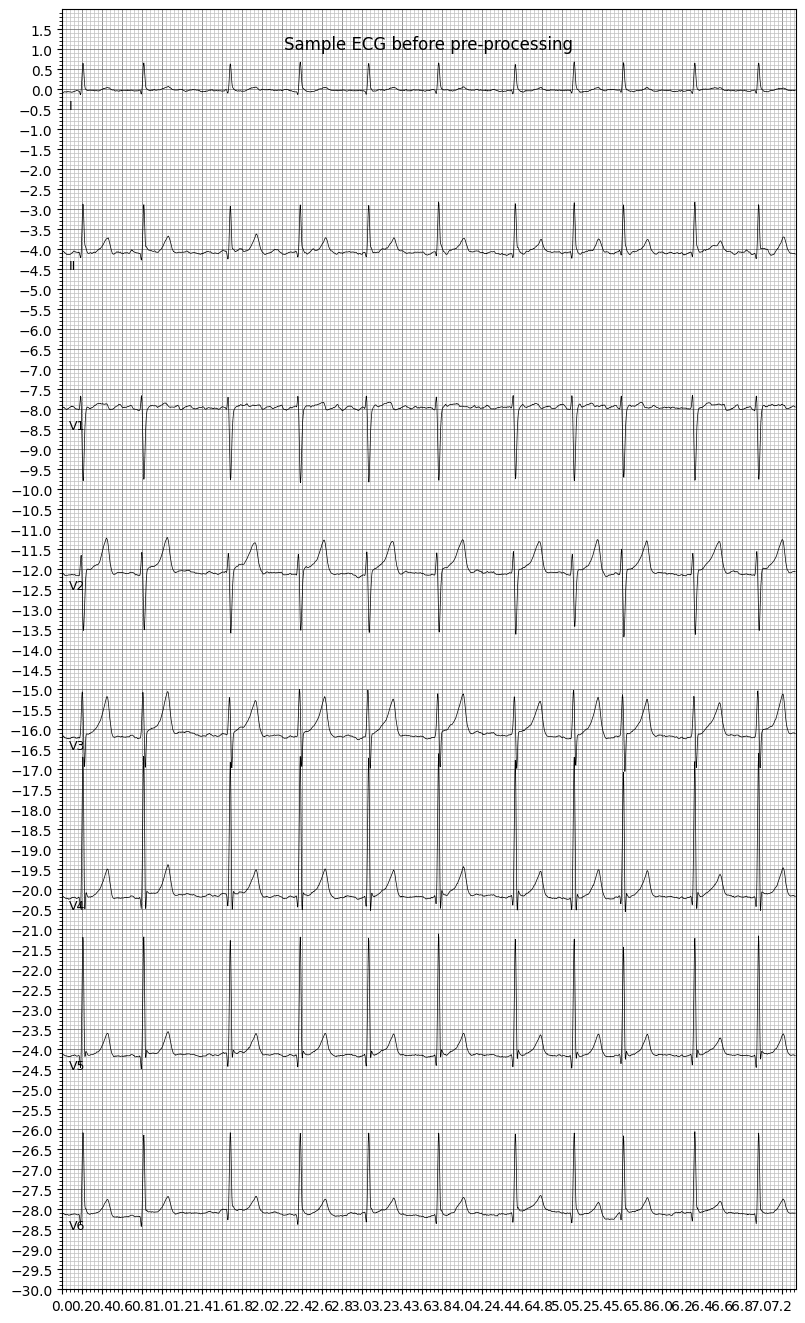

In [48]:
runfile("ecg-preprocessing/ecgprep/read_ecg.py")

PATH_TO_WFDB = 'codesubset/train/TNMG100046'
ecg_sample, sample_rate, _ = read_ecg(PATH_TO_WFDB)

# ECG plot
plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(ecg_sample, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Sample ECG before pre-processing')
plt.show()


The preprocessing consist of:
- resampling all ECG traces to the sample sampling period (400 Hz). Option: ``--new_freq 400``
- zero padding if necessary such that all ECG have the same number of samples (4096). Option: ``--new_len 4096``.
- removing trends in the ECG signal. Option: ``--remove_baseline``
- remove possible power line noise. Option: ``--powerline 60``

You can run the script bellow to plot the same ECG after the preprocessing.  The script also use the  `ecg_plot` library (as you did above).  You can try also with different command line options to see how the preprocessing affects the signal that will be used by the model.

Namespace(path='codesubset/train/TNMG100046', save='', new_freq=400.0, new_len=4096, scale=1, use_all_leads=False, remove_baseline=True, remove_powerline=60.0, fmt='wfdb')


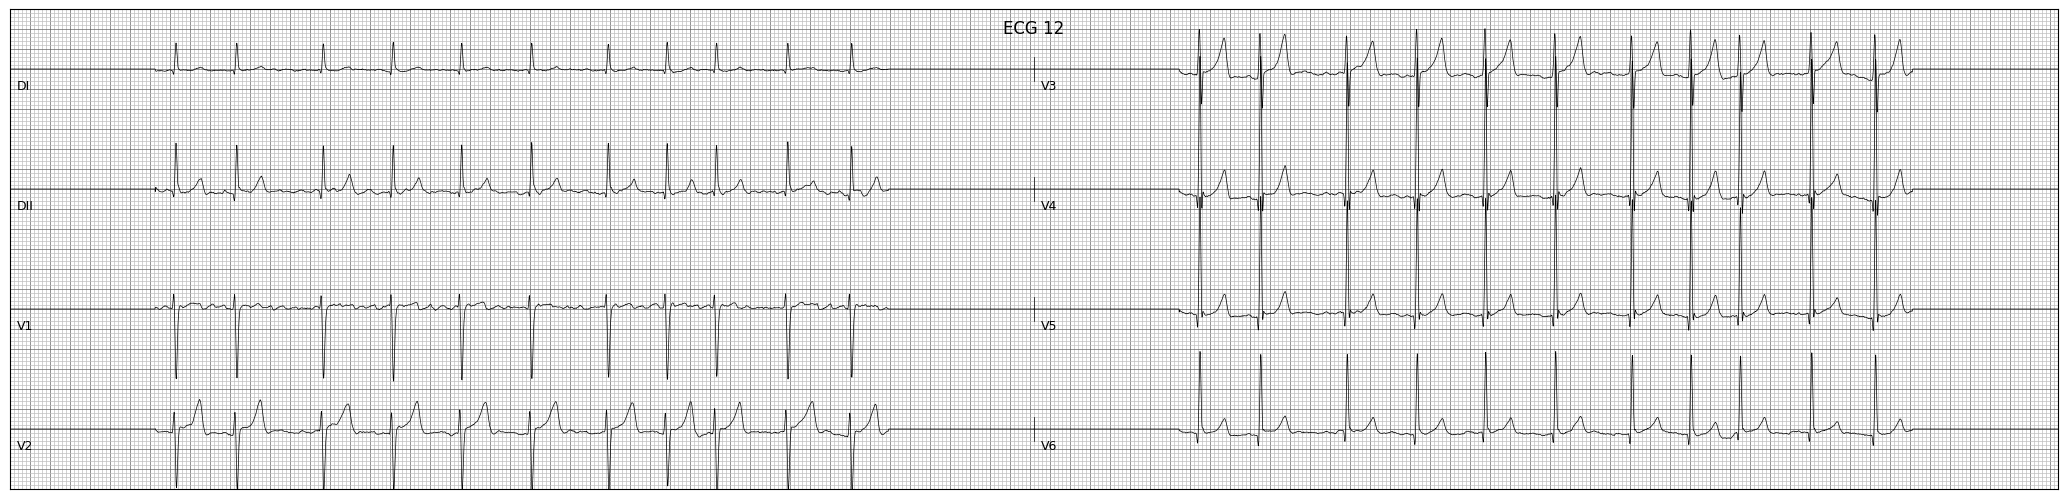

<Figure size 640x480 with 0 Axes>

In [49]:
%run ecg-preprocessing/plot_from_ecg.py codesubset/train/TNMG100046 --new_freq 400 --new_len 4096 --remove_baseline --remove_powerline 60


Next we perform the preprocessing in all exams and convert them into one single h5 file (see [here](https://www.h5py.org/#:~:text=The%20h5py%20package%20is%20a,they%20were%20real%20NumPy%20arrays.) for details about the format). The resulting h5 files contains the traces as arrays with the shape `(number of traces * sequence length * number of leads)` where sequence length is 4096 and number of leads is 8. 
The files `train.h5` and `test.h5` will be saved inside the folder `codesubset/`.

In [50]:
# 3. Generate train
if not exists('codesubset/train.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --remove_powerline 60 codesubset/train/RECORDS.txt codesubset/train.h5
# 3. Generate test
if not exists('codesubset/test.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --remove_powerline 60 codesubset/test/RECORDS.txt codesubset/test.h5

codesubset/train.h5 already exits. Using cached. Delete it manually to recieve it again!
codesubset/test.h5 already exits. Using cached. Delete it manually to recieve it again!


### Coding Task 1: Data Analysis

Before starting to model you have to analyse the dataset. You can be creative in your way of *getting a feeling* for the data. What you have to do is:
- plot an ECG after proprocessing saved in the hdf5 file. For this use the `ecg_plot()` example above and see below for how to access the preprocessed data in h5 format.

Some further ideas to explore are:
- check the balance of the data set,
- evaluate the distribution of age and sex of the patients,
- think about the performance that a best naive classifier would achieve, e.g. by random guessing or always predicting one class.

<br />

**How to access the data?**

You can acces the data in the h5 file in the following way
```
import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']
```
Then, `data[i]` is an numpy array of the $i$ :th ECG exam (including all time points and leads).


<Figure size 640x480 with 0 Axes>

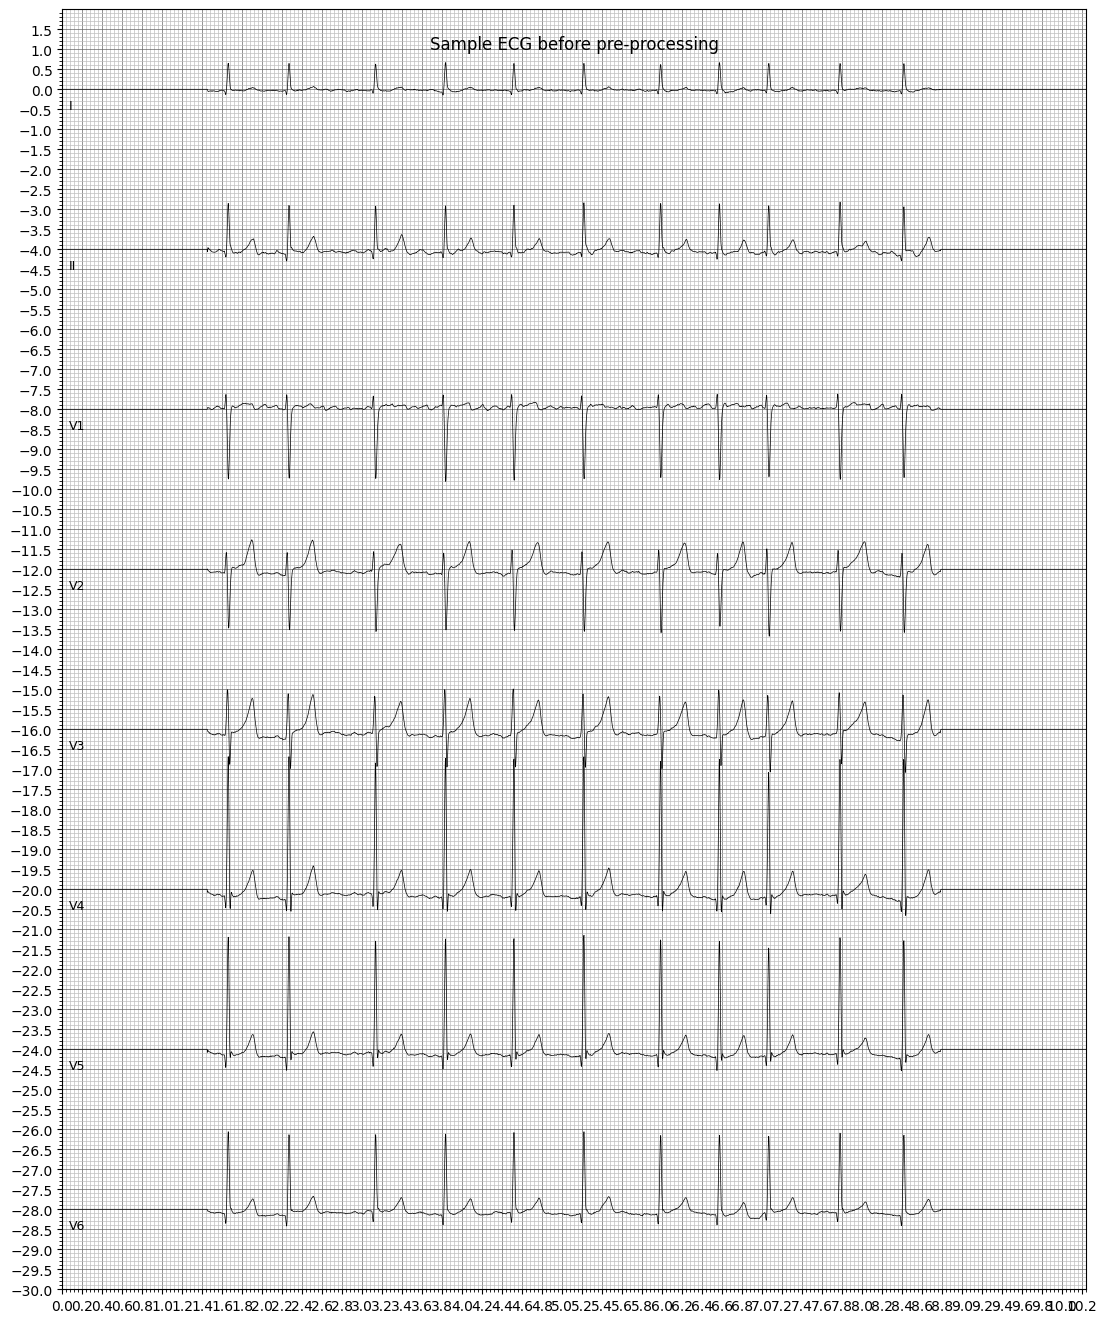

0.6674735515494593
-0.14465266287170273


In [51]:
import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']

ecg_sample = np.transpose(data[0])

plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(ecg_sample, sample_rate=400, style='bw', row_height=8, lead_index=lead, columns=1, title='Sample ECG before pre-processing')
plt.show()

print(max(ecg_sample[0]))
print(min(ecg_sample[0]))


### Explanation task 1: Data Analysis

Please explain your main findings of the data analysis task in a few bullet points. Explain also what the preprocessing does and why it is necessary.

<br />


**<font color='red'>Your explanation here:</font>**

---
## Model

The model class consists of two methods: 
- `__init__(self, args)`: This methods initializes the class, e.g. by using `mymodel=ModelBaseline(args)`.
- `forward(self,input_data)`: This method is called when we run `model_output=mymodel(input_data)`.

The dimension of the input data is  `(batch size * sequence length * number of leads)`. Where **batch size** is a hyperparameter, **sequence length** is the number of ECG time samples (=4096) and **number of leads** (=8).

The `ModelBaseline` (provided below) is a 2 layer model with one convolutional layers and one linear layer. Some explanations: 
- The conv layer downsamples the input traces from 4096 samples to 128 samples and increases the number of channels from 8 (=number of leads) to 32. Here we use a kernel size of 3.
- The linear layer uses the flattened output from the conv and outputs one prediction. Since we have a binary problem, a single prediction is sufficient.


In [52]:
class ModelBaseline(nn.Module):
    def __init__(self,):
        super(ModelBaseline, self).__init__()
        self.kernel_size = 3

        # conv layer
        downsample = self._downsample(4096, 128)
        self.conv1 = nn.Conv1d(in_channels=8, 
                               out_channels=32, 
                               kernel_size=self.kernel_size, 
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)
        
        # linear layer
        self.lin = nn.Linear(in_features=32*128,
                             out_features=1)
        
        # ReLU
        self.relu = nn.ReLU()

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)


    def forward(self, x):
        x= x.transpose(2,1)

        x = self.relu(self.conv1(x))
        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)

        return x

### Coding Task 2: Define your model

In the cell below you have to define your model. You can be inspired by the baseline model above but you can also define any other kind of neural network architecture.

In [53]:
class Model(nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
        self.kernel_size = 3

        # conv layer
        downsample = self._downsample(4096, 128)
        self.conv1 = nn.Conv1d(in_channels=8, 
                               out_channels=32, 
                               kernel_size=self.kernel_size, 
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)
        
        # linear layer
        self.lin = nn.Linear(in_features=32*128,
                             out_features=1)
        
        # ReLU
        self.relu = nn.ReLU()

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)


    def forward(self, x):
        x = x.transpose(2,1)
        x = self.conv1(x)
        x = self.relu(x)
        x_flat = x.view(x.size(0), -1)
        x = self.lin(x_flat)

        return x

In [54]:
def _padding(downsample, kernel_size):
    """Compute required padding"""
    padding = max(0, int(np.floor((kernel_size - downsample + 1) / 2)))
    return padding


def _downsample(n_samples_in, n_samples_out):
    """Compute downsample rate"""
    downsample = int(n_samples_in // n_samples_out)
    if downsample < 1:
        raise ValueError("Number of samples should always decrease")
    if n_samples_in % n_samples_out != 0:
        raise ValueError("Number of samples for two consecutive blocks "
                         "should always decrease by an integer factor.")
    return downsample


class ResBlock1d(nn.Module):
    """Residual network unit for unidimensional signals."""

    def __init__(self, n_filters_in, n_filters_out, downsample, kernel_size, dropout_rate):
        if kernel_size % 2 == 0:
            raise ValueError("The current implementation only support odd values for `kernel_size`.")
        super(ResBlock1d, self).__init__()
        # Forward path
        padding = _padding(1, kernel_size)
        self.conv1 = nn.Conv1d(n_filters_in, n_filters_out, kernel_size, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm1d(n_filters_out)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        padding = _padding(downsample, kernel_size)
        self.conv2 = nn.Conv1d(n_filters_out, n_filters_out, kernel_size,
                               stride=downsample, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(n_filters_out)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Skip connection
        skip_connection_layers = []
        # Deal with downsampling
        if downsample > 1:
            maxpool = nn.MaxPool1d(downsample, stride=downsample)
            skip_connection_layers += [maxpool]
        # Deal with n_filters dimension increase
        if n_filters_in != n_filters_out:
            conv1x1 = nn.Conv1d(n_filters_in, n_filters_out, 1, bias=False)
            skip_connection_layers += [conv1x1]
        # Build skip conection layer
        if skip_connection_layers:
            self.skip_connection = nn.Sequential(*skip_connection_layers)
        else:
            self.skip_connection = None

    def forward(self, x, y):
        """Residual unit."""
        if self.skip_connection is not None:
            y = self.skip_connection(y)
        else:
            y = y
        # 1st layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        # 2nd layer
        x = self.conv2(x)
        x += y  # Sum skip connection and main connection
        y = x
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        return x, y


class ResNet1d(nn.Module):
    """Residual network for unidimensional signals.
    Parameters
    ----------
    input_dim : tuple
        Input dimensions. Tuple containing dimensions for the neural network
        input tensor. Should be like: ``(n_filters, n_samples)``.
    blocks_dim : list of tuples
        Dimensions of residual blocks.  The i-th tuple should contain the dimensions
        of the output (i-1)-th residual block and the input to the i-th residual
        block. Each tuple shoud be like: ``(n_filters, n_samples)``. `n_samples`
        for two consecutive samples should always decrease by an integer factor.
    dropout_rate: float [0, 1), optional
        Dropout rate used in all Dropout layers. Default is 0.8
    kernel_size: int, optional
        Kernel size for convolutional layers. The current implementation
        only supports odd kernel sizes. Default is 17.
    References
    ----------
    .. [1] K. He, X. Zhang, S. Ren, and J. Sun, "Identity Mappings in Deep Residual Networks,"
           arXiv:1603.05027, Mar. 2016. https://arxiv.org/pdf/1603.05027.pdf.
    .. [2] K. He, X. Zhang, S. Ren, and J. Sun, "Deep Residual Learning for Image Recognition," in 2016 IEEE Conference
           on Computer Vision and Pattern Recognition (CVPR), 2016, pp. 770-778. https://arxiv.org/pdf/1512.03385.pdf
    """

    def __init__(self, input_dim, blocks_dim, n_classes, kernel_size=17, dropout_rate=0.8):
        super(ResNet1d, self).__init__()
        # First layers
        n_filters_in, n_filters_out = input_dim[0], blocks_dim[0][0]
        n_samples_in, n_samples_out = input_dim[1], blocks_dim[0][1]
        downsample = _downsample(n_samples_in, n_samples_out)
        padding = _padding(downsample, kernel_size)
        self.conv1 = nn.Conv1d(n_filters_in, n_filters_out, kernel_size, bias=False,
                               stride=downsample, padding=padding)
        self.bn1 = nn.BatchNorm1d(n_filters_out)

        # Residual block layers
        self.res_blocks = []
        for i, (n_filters, n_samples) in enumerate(blocks_dim):
            n_filters_in, n_filters_out = n_filters_out, n_filters
            n_samples_in, n_samples_out = n_samples_out, n_samples
            downsample = _downsample(n_samples_in, n_samples_out)
            resblk1d = ResBlock1d(n_filters_in, n_filters_out, downsample, kernel_size, dropout_rate)
            self.add_module('resblock1d_{0}'.format(i), resblk1d)
            self.res_blocks += [resblk1d]

        # Linear layer
        n_filters_last, n_samples_last = blocks_dim[-1]
        last_layer_dim = n_filters_last * n_samples_last
        self.lin = nn.Linear(last_layer_dim, n_classes)
        self.n_blk = len(blocks_dim)

    def forward(self, x):
        """Implement ResNet1d forward propagation"""
        x = x.transpose(2,1)
        # First layers
        x = self.conv1(x)
        x = self.bn1(x)

        # Residual blocks
        y = x
        for blk in self.res_blocks:
            x, y = blk(x, y)

        # Flatten array
        x = x.view(x.size(0), -1)

        # Fully conected layer
        x = self.lin(x)
        return x

### Explanation Task 2: Final Model
Please explain and motivate in short sentences or bullet points the choice of your final model.

<br />


**<font color='red'>Your explanation here:</font>**


---
## Train function

The function `train(...)` is called to in every epoch to train the model. The function loads the training data, makes predictions, compares predictions with true labels in the loss function and adapting the model parameters using stochastic gradient descent.

In the code cell below there is the basic structure to load data from the data loader and to log your loss. The arguments of the function are explained by the use in the `main(...)` function below.

If you are unfamiliar with PyTorch training loops, then this official [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) might help (especially section "4. Train your Network").

### Coding Task 3: Fill training loop

Fill the code cell below such that the model is training when `train(...)` is called.

In [55]:
def train_loop(epoch, dataloader, model, optimizer, loss_function, device, adversarial=False, adv_eps=4e-2, adv_alpha=1e-2, adv_steps=10):
    # model to training mode (important to correctly handle dropout or batchnorm layers)
    model.train()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    # progress bar def
    train_pbar = tqdm(dataloader, desc="Training Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # training loop
    for traces, diagnoses in train_pbar:
        optimizer.zero_grad()
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces.to(device), diagnoses.to(device)

        # forward pass
        output = model(traces)
        
        # adversarial training
        if adversarial:
            adv_traces = pgd_attack(model, traces, diagnoses, device, loss_function=loss_function, eps=adv_eps, alpha=adv_alpha, steps=adv_steps)
            adv_output = model(adv_traces)
            
            # let loss be the average of the original and adversarial loss
            loss = (loss_function(output, diagnoses) + loss_function(adv_output, diagnoses)) / 2
            
        else:
            loss = loss_function(output, diagnoses)
                
        # backward pass
        loss.backward()
        optimizer.step()

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        train_pbar.set_postfix({'loss': total_loss / n_entries})
    train_pbar.close()
    return total_loss / n_entries

---
## Eval function

The `eval(...)` function is similar to the `train(...)` function but is used to evaluate the model on validation data without adapting the model parameters. You can prohibit computing gradients by using a `with torch.no_grad():` statement.

Currenlty only the loss is logged here. Additionally you have to collect all your predictions and the true values in order to compute more metrics such as AUROC.

### Coding Task 4: Fill evaluation loop
Fill the code cell below such we obtain model predictions to evaluate the validation loss and collect the predictoin in order to compute other validation metrics in the `main(...)` function.

In [56]:
def eval_loop(epoch, dataloader, model, loss_function, device, adversarial=False, adv_eps=4e-2, adv_alpha=1e-2, adv_steps=10):
    # model to evaluation mode (important to correctly handle dropout or batchnorm layers)
    model.eval()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    valid_pred, valid_true = [], []
    # progress bar def
    eval_pbar = tqdm(dataloader, desc="Evaluation Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # evaluation loop
    for traces_cpu, diagnoses_cpu in eval_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces_cpu.to(device), diagnoses_cpu.to(device)
        
        if adversarial:
            # generate adversarial samples
            traces = pgd_attack(model, traces, diagnoses, device, eps=adv_eps, alpha=adv_alpha, steps=adv_steps)

        with torch.no_grad():
            # forward pass
            output = model(traces)
            loss = loss_function(output, diagnoses)
            
            # save predictions
            valid_pred.append(output.detach().cpu().numpy())
            valid_true.append(diagnoses.detach().cpu().numpy())

            # Update accumulated values
            total_loss += loss.detach().cpu().numpy()
            n_entries += len(traces)

        # Update progress bar
        eval_pbar.set_postfix({'loss': total_loss / n_entries})
    eval_pbar.close()
    return total_loss / n_entries, np.vstack(valid_pred), np.vstack(valid_true)

---
## Run Training

In the code cell below there are some initial (non-optimal!) training hyperparameters. Further, we combine everything from above into training code. That means that we build the dataloaders, define the model/loss/optimizer and then train/validate the model over multiple epochs. Here, we save the model with the lowest validation loss as the best model.

### Coding Task 5: Combine everything to train/validate the model

The following tasks are necessary in the code below
- split the data into training and validation data
- define the loss function
- decide and implement validation metric(s) to evaluate and compare the model on

Optional task:
- include learning rate scheduler
- take specific care about possible data inbalance

### Coding Task 6: Run your model and adapt hyperparameters

After you combined everything in task 5, now you run the code to evaluate the model. Based on the resulting validation metrics you tune
- the training hyperparameters
- the model architecture
- the model hyperparameters.

### Explanation Task 3: Hyperparameter
Please explain and motivate in short sentences or bullet points the final choice of hyperparamer and how you developed them.

<br />


**<font color='red'>Your explanation here:</font>**


In [57]:


# hyperparameters
learning_rate = 1e-3
weight_decay = 1e-2  
num_epochs = 20
batch_size = 64
train_cut = 0.8

In [58]:

# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

path_to_h5_train, path_to_csv_train, path_to_records = 'codesubset/train.h5', 'codesubset/train.csv', 'codesubset/train/RECORDS.txt'
# load traces
traces = torch.tensor(h5py.File(path_to_h5_train, 'r')['tracings'][()], dtype=torch.float32)
# load labels
ids_traces = [int(x.split('TNMG')[1]) for x in list(pd.read_csv(path_to_records, header=None)[0])] # Get order of ids in traces
df = pd.read_csv(path_to_csv_train)
df.set_index('id_exam', inplace=True)
df = df.reindex(ids_traces) # make sure the order is the same
labels = np.array(df['AF'])

# one-hot encode labels
# labels = pd.get_dummies(labels)

labels = torch.tensor(labels, dtype=torch.float32).reshape(-1,1)

# load dataset
dataset = TensorDataset(traces, labels)
len_dataset = len(dataset)
n_classes = len(torch.unique(labels))

# split data
len_train = int(train_cut * len_dataset)
len_valid = len_dataset - len_train
dataset_train, dataset_valid = random_split(dataset, [len_train, len_valid])

# build data loaders
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)                         
tqdm.write("Done!\n")

Use device: cuda

Done!



In [59]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score

tqdm.write("Define model...")
model = ResNet1d(input_dim=(8, 4096),n_classes=1, blocks_dim=[(64, 4096), (128, 1024), (196, 256), (256, 64), (320, 16)])#, kernel_size=3, dropout_rate=0.8
model.to(device=device)
tqdm.write("Done!\n")


loss_function = nn.BCEWithLogitsLoss()
#loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

tqdm.write("Training...")
best_loss = np.Inf
# allocation
train_loss_all, valid_loss_all, adv_valid_loss_all = [], [], []
auroc_all, ap_all, accuracy_all, f1_all = [], [], [], []

# loop over epochs
for epoch in trange(1, num_epochs + 1):
    # training loop
    adversarial = False #if epoch <= 10 else True
    train_loss = train_loop(epoch, train_dataloader, model, optimizer, loss_function, device, adversarial=adversarial)
    # validation loop
    valid_loss, y_pred, y_true = eval_loop(epoch, valid_dataloader, model, loss_function, device)
    adv_valid_loss, adv_y_pred, adv_y_true = eval_loop(epoch, valid_dataloader, model, loss_function, device, adversarial=True)

    # collect losses
    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)
    adv_valid_loss_all.append(adv_valid_loss)

    # compute validation metrics for performance evaluation    
    auroc = roc_auc_score(y_true, y_pred)
    ap = average_precision_score(y_true, y_pred)
    
    # apply sigmoid to y_pred
    y_pred = torch.sigmoid(torch.tensor(y_pred)).numpy()
    y_pred = np.round(y_pred)
    
    # compute accuracy    
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='binary')
    
    auroc_all.append(auroc)
    ap_all.append(ap)
    accuracy_all.append(accuracy)
    f1_all.append(f1)

    # # save best model: here we save the model only for the lowest validation loss
    # if valid_loss < best_loss:
    #     # Save model parameters
    #     torch.save({'model': model.state_dict()}, 'model_adv.pth') 
    #     # Update best validation loss
    #     best_loss = valid_loss
    #     # statement
    #     model_save_state = "Best model -> saved"
    # else:
    #     model_save_state = ""
    
    torch.save({'model': model.state_dict()}, 'model.pth') 

    # Print message
    tqdm.write('Epoch {epoch:2d}: \t'
                'Train Loss {train_loss:.6f} \t'
                'Valid Loss {valid_loss:.6f} \t'
                'Adversarial Loss {adv_valid_loss:.6f} \t'
                'AUROC {auroc:.6f} \t'
                #'{model_save}'
                .format(epoch=epoch,
                        train_loss=train_loss,
                        valid_loss=valid_loss,
                        adv_valid_loss=adv_valid_loss,
                        auroc=auroc,
                        #model_save=model_save_state
                        )
                    )

    # Update learning rate with lr-scheduler
    if lr_scheduler:
        lr_scheduler.step(valid_loss)

Define model...
Done!

Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  1: 	Train Loss 0.009440 	Valid Loss 0.009512 	Adversarial Loss 0.017657 	AUROC 0.800025 	


Training Epoch  2:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  2: 	Train Loss 0.007275 	Valid Loss 0.007225 	Adversarial Loss 0.093462 	AUROC 0.913622 	


Training Epoch  3:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  3: 	Train Loss 0.004729 	Valid Loss 0.003802 	Adversarial Loss 0.220337 	AUROC 0.974348 	


Training Epoch  4:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  4: 	Train Loss 0.003283 	Valid Loss 0.002099 	Adversarial Loss 0.245828 	AUROC 0.989339 	


Training Epoch  5:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  5: 	Train Loss 0.002188 	Valid Loss 0.001891 	Adversarial Loss 0.245911 	AUROC 0.991566 	


Training Epoch  6:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  6: 	Train Loss 0.002061 	Valid Loss 0.002314 	Adversarial Loss 0.230969 	AUROC 0.987991 	


Training Epoch  7:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  7: 	Train Loss 0.001862 	Valid Loss 0.002146 	Adversarial Loss 0.261778 	AUROC 0.990496 	


Training Epoch  8:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  8: 	Train Loss 0.001664 	Valid Loss 0.001906 	Adversarial Loss 0.264810 	AUROC 0.992624 	


Training Epoch  9:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  9: 	Train Loss 0.001618 	Valid Loss 0.001685 	Adversarial Loss 0.244523 	AUROC 0.993682 	


Training Epoch 10:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: 	Train Loss 0.001678 	Valid Loss 0.001841 	Adversarial Loss 0.280164 	AUROC 0.992418 	


Training Epoch 11:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: 	Train Loss 0.001553 	Valid Loss 0.001667 	Adversarial Loss 0.282761 	AUROC 0.994079 	


Training Epoch 12:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: 	Train Loss 0.001477 	Valid Loss 0.002178 	Adversarial Loss 0.307524 	AUROC 0.992765 	


Training Epoch 13:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: 	Train Loss 0.001410 	Valid Loss 0.002034 	Adversarial Loss 0.273830 	AUROC 0.992147 	


Training Epoch 14:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: 	Train Loss 0.001470 	Valid Loss 0.001804 	Adversarial Loss 0.278585 	AUROC 0.992580 	


Training Epoch 15:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: 	Train Loss 0.001400 	Valid Loss 0.002271 	Adversarial Loss 0.298582 	AUROC 0.992772 	


Training Epoch 16:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluation Epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluation Epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16: 	Train Loss 0.001415 	Valid Loss 0.001701 	Adversarial Loss 0.317471 	AUROC 0.994197 	


Training Epoch 17:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluation Epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluation Epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17: 	Train Loss 0.001342 	Valid Loss 0.001731 	Adversarial Loss 0.297546 	AUROC 0.993614 	


Training Epoch 18:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluation Epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluation Epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18: 	Train Loss 0.001395 	Valid Loss 0.001670 	Adversarial Loss 0.301083 	AUROC 0.993945 	


Training Epoch 19:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluation Epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluation Epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19: 	Train Loss 0.001290 	Valid Loss 0.001890 	Adversarial Loss 0.335553 	AUROC 0.993367 	


Training Epoch 20:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluation Epoch 20:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluation Epoch 20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20: 	Train Loss 0.001293 	Valid Loss 0.001762 	Adversarial Loss 0.356731 	AUROC 0.994174 	


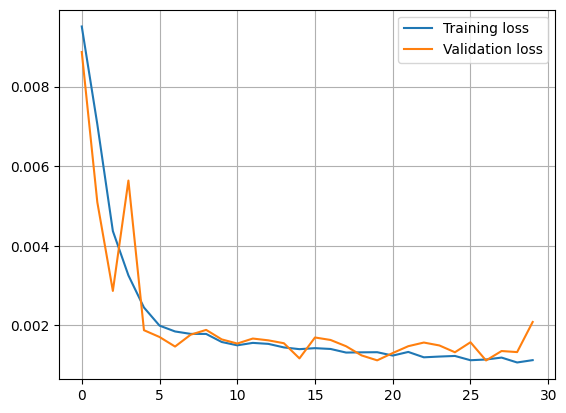

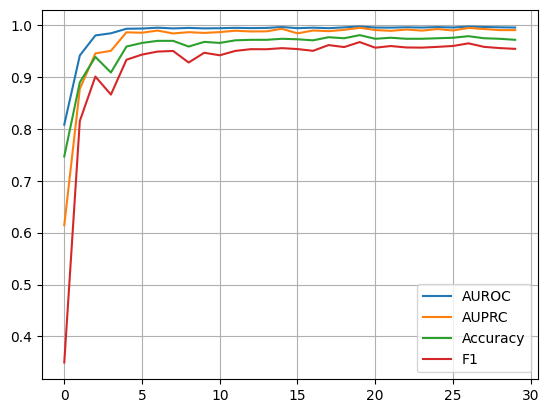

In [ ]:
# plot training and validation loss
plt.figure()
plt.plot(train_loss_all, label='Training loss')
plt.plot(valid_loss_all, label='Validation loss')
plt.legend()
plt.grid()
plt.show()

# plot validation metrics
plt.figure()
plt.plot(auroc_all, label='AUROC')
plt.plot(ap_all, label='AUPRC')
plt.plot(accuracy_all, label='Accuracy')
plt.plot(f1_all, label='F1')
plt.legend()
plt.grid()
plt.show()

---
## Model Testing

Since we saved our best model, we can now load the trained model and make predictions on the test data set. We save the predictions in a csv file which will be uploaded as part of the deliverables. Note that we take a `Sigmoid()` function on the model prediction in order to obtain hard predction (0,1) instead of soft predictions (probabilities). 

### Coding Task 7: Make prediction for test data

Here you do not really need to code but you have to:
- replace the baseline model with your model. If you do not use colab then change the path to the model location to load the trained model)
- run the script. The soft and hard predictions are saved in the variables `soft_pred` and `hard_pred`.
- upload your predictions to the leaderboard online (see instruction details below). 

In [19]:
# build the dataloader once and re-use when running the cell below possibly multiple times.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =============== Build data loaders ==========================================#
tqdm.write("Building data loaders...")
# load data
path_to_h5_test, path_to_csv_test = 'codesubset/test.h5', 'codesubset/test.csv'
traces = torch.tensor(h5py.File(path_to_h5_test, 'r')['tracings'][()], dtype=torch.float32)
dataset = TensorDataset(traces)
len_dataset = len(dataset)
# build data loaders
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
tqdm.write("Done!\n")

Building data loaders...
Done!



In [20]:
# =============== Define model ================================================#
tqdm.write("Define model...")
model = ResNet1d(input_dim=(8, 4096),n_classes=1, blocks_dim=[(64, 4096), (128, 1024), (196, 256), (256, 64), (320, 16)])#, kernel_size=3, dropout_rate=0.8

# load stored model parameters
ckpt = torch.load('model_best.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(ckpt['model'])
# put model on device
model.to(device=device)
tqdm.write("Done!\n")



Define model...
Done!



In [35]:
# Evaluate without adversarial examples
valid_loss, y_pred, y_true = eval_loop(0, valid_dataloader, model, loss_function, device, adversarial=False)

auroc = roc_auc_score(y_true, y_pred)
ap = average_precision_score(y_true, y_pred)

# apply sigmoid to y_pred
y_pred = torch.sigmoid(torch.tensor(y_pred)).numpy()
y_pred = np.round(y_pred)

# compute accuracy    
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='binary')

# Evaluate with adversarial examples
adv_valid_loss, adv_y_pred, adv_y_true = eval_loop(0, valid_dataloader, model, loss_function, device, adversarial=True, adv_eps=4e-3, adv_alpha=1e-3, adv_steps=10)

adv_auroc = roc_auc_score(adv_y_true, adv_y_pred)
adv_ap = average_precision_score(adv_y_true, adv_y_pred)

# apply sigmoid to y_pred
adv_y_pred = torch.sigmoid(torch.tensor(adv_y_pred)).numpy()
adv_y_pred = np.round(adv_y_pred)

# compute accuracy
adv_accuracy = accuracy_score(adv_y_true, adv_y_pred)
adv_f1 = f1_score(adv_y_true, adv_y_pred, average='binary')

# Print table comparing results
from tabulate import tabulate

table = [["", "Accuracy", "AUROC", "AUPRC", "F1"],
            ["No adversarial", accuracy, auroc, ap, f1],
            ["Adversarial", adv_accuracy, adv_auroc, adv_ap, adv_f1]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

Evaluation Epoch  0:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/32 [00:00<?, ?it/s]

╒════════════════╤════════════╤══════════╤══════════╤══════════╕
│                │   Accuracy │    AUROC │    AUPRC │       F1 │
╞════════════════╪════════════╪══════════╪══════════╪══════════╡
│ No adversarial │     0.977  │ 0.996649 │ 0.992644 │ 0.960481 │
├────────────────┼────────────┼──────────┼──────────┼──────────┤
│ Adversarial    │     0.8395 │ 0.916512 │ 0.809514 │ 0.688652 │
╘════════════════╧════════════╧══════════╧══════════╧══════════╛


<Figure size 640x480 with 0 Axes>

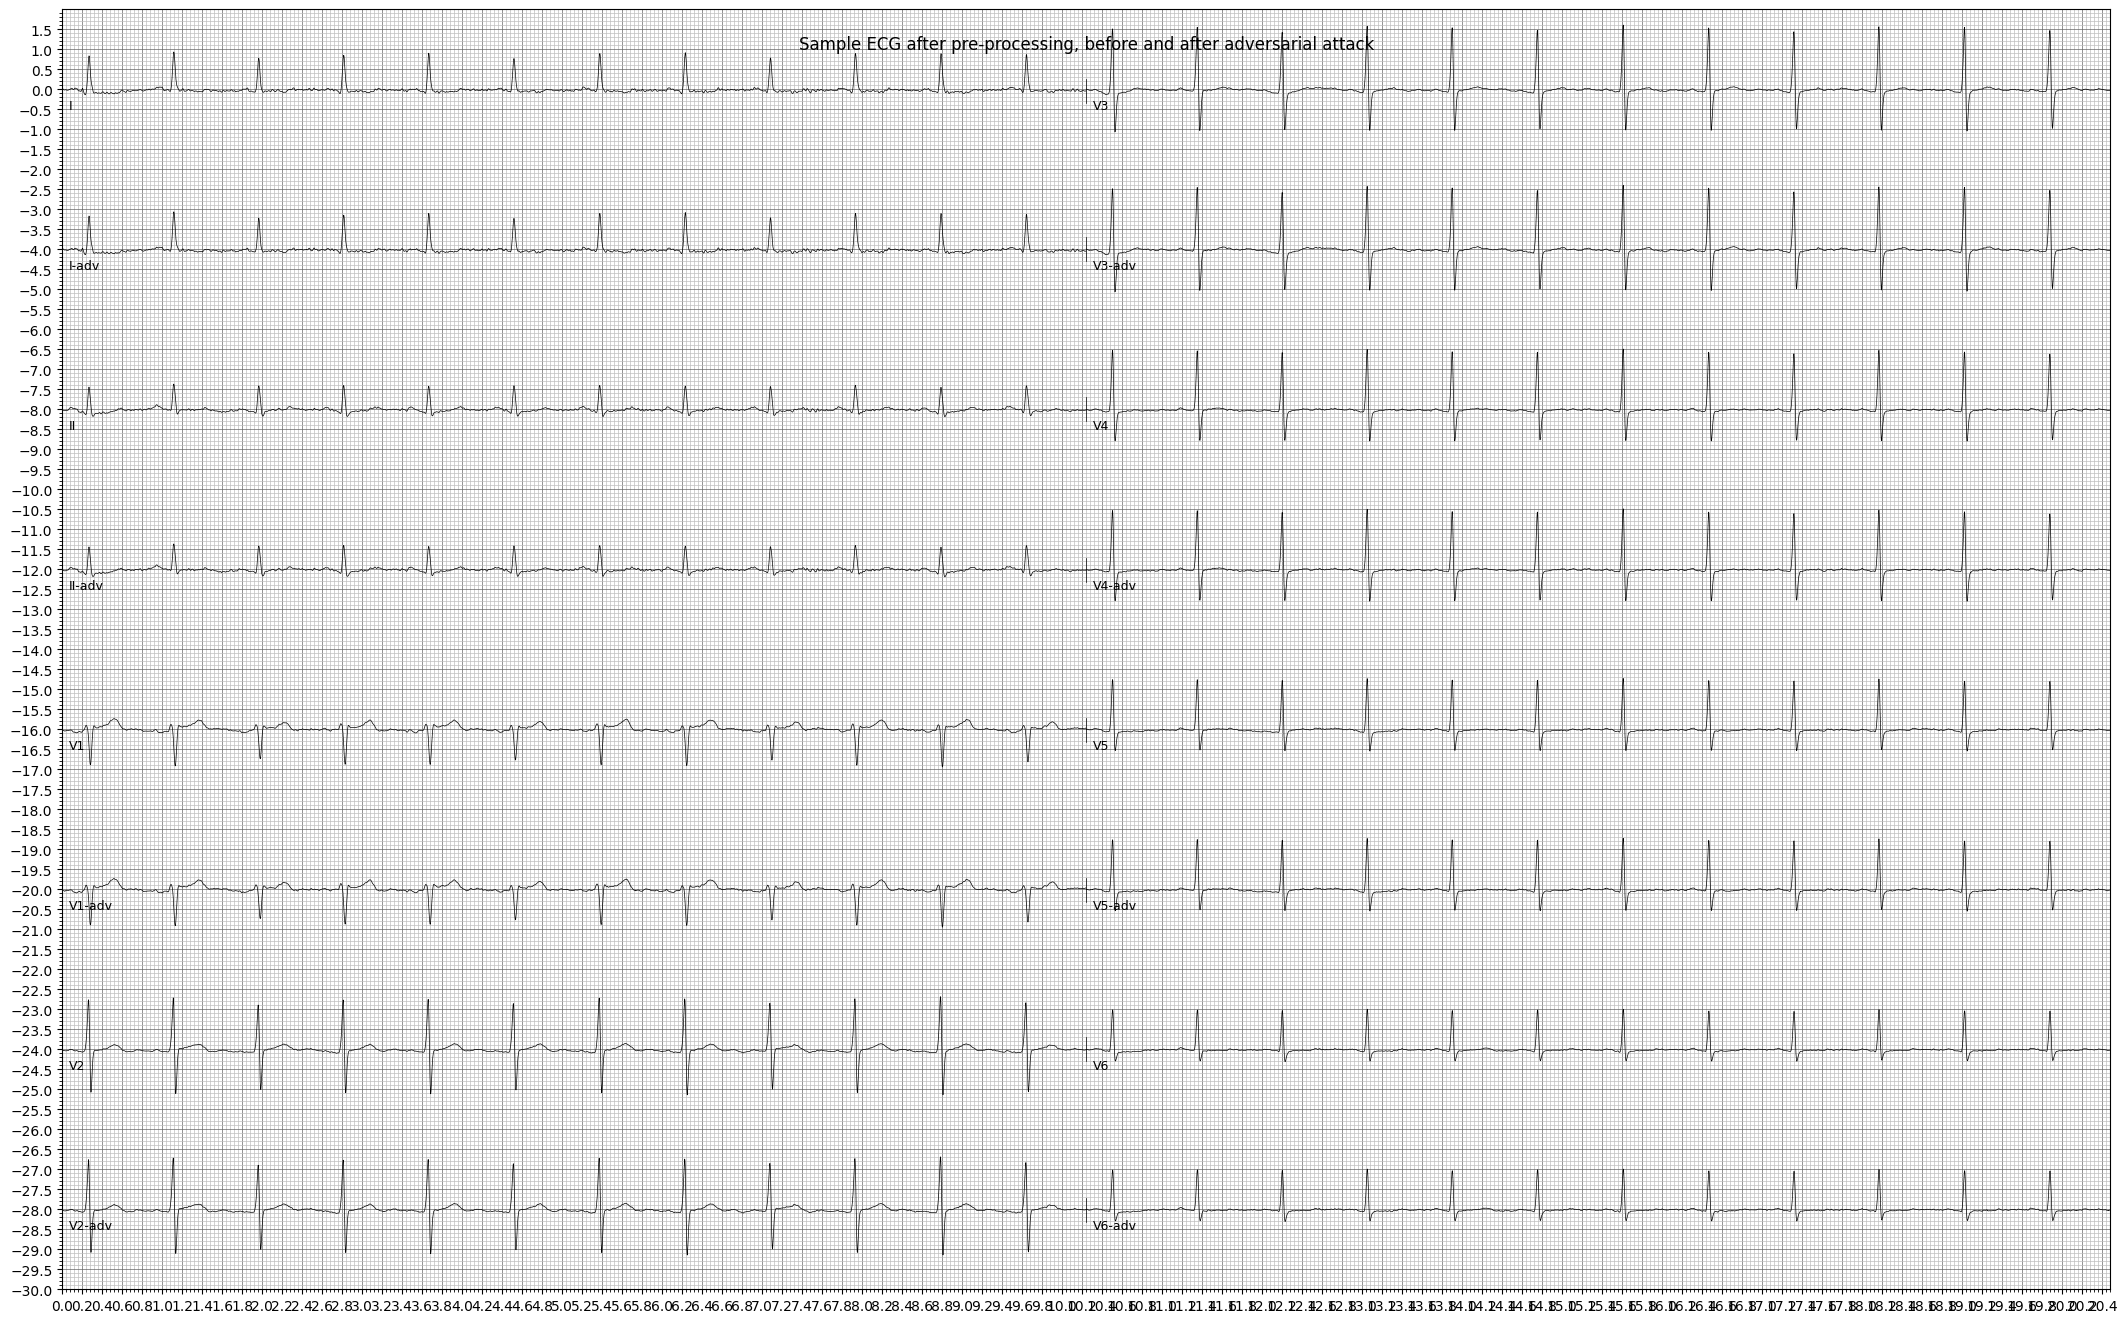

In [37]:
# Plot some adversarial examples
traces, diagnoses = next(iter(valid_dataloader))

ecg_sample = np.transpose(traces[0])

# Generate adversarial examples
traces = pgd_attack(model, traces, diagnoses, device, eps=4e-2, alpha=1e-2, steps=10)

ecg_sample_adv = np.transpose(traces[0].cpu().numpy())

# Concatenate the two ecgs to (16, 4096)
#ecg_sample = np.concatenate((ecg_sample, ecg_sample_adv), axis=0)

# Interleave them instead such that the adversarial example is in between the original
ecg_sample = np.array([val for pair in zip(ecg_sample, ecg_sample_adv) for val in pair])

plt.figure()
#lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'I-adv', 'II-adv', 'V1-adv', 'V2-adv', 'V3-adv', 'V4-adv', 'V5-adv', 'V6-adv']
lead = ['I', 'I-adv', 'II', 'II-adv', 'V1', 'V1-adv', 'V2', 'V2-adv', 'V3', 'V3-adv', 'V4', 'V4-adv', 'V5', 'V5-adv', 'V6', 'V6-adv']
ecg_plot.plot(ecg_sample, sample_rate=400, style='bw', row_height=8, lead_index=lead, columns=2, title='Sample ECG after pre-processing, before and after adversarial attack')
plt.show()


In [ ]:
# =============== Evaluate model ==============================================#
model.eval()
# allocation
test_pred = torch.zeros(len_dataset,1)
# progress bar def
test_pbar = tqdm(test_dataloader, desc="Testing")
# evaluation loop
end=0
for traces in test_pbar:
    # data to device
    traces = traces[0].to(device)
    start = end
    with torch.no_grad():
        # Forward pass
        model_output = model(traces)

        # store output
        end = min(start + len(model_output), test_pred.shape[0])
        test_pred[start:end] = torch.nn.Sigmoid()(model_output).detach().cpu()

test_pbar.close()

# =============== Save predictions ============================================#
soft_pred = np.stack((1-test_pred.numpy(), test_pred.numpy()),axis=1).squeeze()

To upload your predictions to the leaderboard, use the following code. There are the following steps to follow:
1. Download the GitHub repository for the leaderboard submission system.
2. Register your team with a **team id** and **password**. The password ensures that only your team can upload to your team id. Do only run the registration once.
3. Upload you predictions as a new submission. There are some things to obey here:
    - For each submission you have to attach a note for you to keep track of the submission in the leaderboard and for us to know which submission you refer to in your explanation. Choose something meaningful such as "submission A" or "model B".
    - You can only get one prediction evaluated per day and you get the score the following day. If you do multiple submissions on the same day, the initial submission will be overwritten and thus only the final submission will be evaluated.
    - Only a maximum of ***FIVE*** submissions will be evaluated. So make them count! (If you update an submission before it is evaluated it doesn't count)
    - The evaluation score is published with you team_id and note at http://hyperion.it.uu.se:5050/leaderboard



In [ ]:
# 1. Download repository for leaderboard submission system
if not exists('leaderboard'):
    !git clone https://gist.github.com/3ff6c4c867331c0bf334301842d753c7.git leaderboard

leaderboard already exits. Using cached. Delete it manually to recieve it again!


In [ ]:
# 2. Registration of your team
host = "http://hyperion.it.uu.se:5050/"
runfile("leaderboard/leaderboard_helpers.py")

"""
TASK: Decide for a team_id (max 20 chars) and password. 
Do not change this after you have registered your team
"""
team_id = 'Arvid' #Fill in a string
password = 'asdf' #Fill in a string

# run the registration
r = register_team(team_id, password)
if (r.status_code == 201):
    print("Team registered successfully! Good luck")
elif not (r.status_code == 200):
    raise Exception("You can not change your password once created. If you need help, please contact the teachers")

In [ ]:
# 3. Upload the prediction as submission

# Write a note about the training procedure so you can identify it in the leaderboard. e.g. 5 epochs, or First  (Max 20 characters)
"""
TASK: Add a note for you submission
"""
note = '1d resnet 0.9 train' #Fill in a string

# Submit the predictions to the leaderboard. Note, this also saves your submissions in your colab folder
r = submit(team_id, password, soft_pred.tolist(), note)
if r.status_code == 201:
    print("Submission successful!")
elif r.status_code == 200:
    print("Submission updated!")

Submission successful!


### Explanation Task 4: Submissions
One of the grading criteria are three submissions to the leaderboard. List the three main submissions in the table below and explain the main changes in your code for each submission.

<br />


**<font color='red'>Your explanation here:</font>**

Your team id: **<font color='red'>Fill in</font>**

| Submission note | Accuracy | F1 | AUC | AP | Submission description |
| --------------- | -------- | -- | --  | -- | ---------------------- |
|xxx              | 0        | 0  | 0   | 0  | desc                   |
|xxx              | 0        | 0  | 0   | 0  | desc                   |
|xxx              | 0        | 0  | 0   | 0  | desc                   |

### Explanation Task 5: Reflection on Metrics
Your were asked to reach a certain value in AUC and AP while maximising F1 for the leaderboard position. Explain in bullet points what aspect each of the metrics covers and why it is important not to just focus on one metric. What can happen if you only focus on AUC for example?

<br />

**<font color='red'>Your explanation here:</font>**